# Ellipsoid Method

Gabriel Konar-Steenberg, 2022-10-10

## Problem Statement

"Create your own convex optimization problem of the following type: your problem is 2-dimensional, your constrained domain is a polygon with at least 5 sides (define your constraints using inequalities), and your cost function to minimize is:
$$f(x, y) = a|x_0-x|+(y_0-y)^4$$
(choose your own parameter value $a$ and choose $(x_0, y_0)$ point inside of your constrained domain but not as a start point for your iterations). Make your choice of a cutting plane method (ellipsoids or centers of gravity).… [O]utput a plot that illustrates a convergence toward the analytical result $(x_0, y_0)$…."

## Solution

We will use the the ellipsoid method from Sébastien Bubeck, "Convex Optimization, Algorithms and Complexity."

First, let's define all our parameters and get some graphing apparatus up and running:

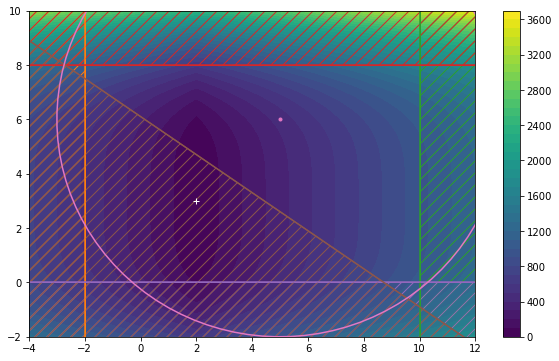

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters of the problem
n = 2  # dimensionality
a = 120
x0 = 2
y0 = 3
constraints = [  # Format: normal vector (gets normalized later), offset distance from origin.
    [(-1, 0), 2],
    [(1, 0), 10],
    [(0, 1), 8],
    [(0, -1), 0],
    [(-7, -10), -5]]
def f(x, y):
    return a*abs(x0-x)+(y0-y)**4
c0 = (5, 6)
R = 8
E0 = (c0, (R**2)*np.eye(n))  # Format: center, H matrix (note that it's H^-1 in the ellipse formula)

# Let's always work with normalized normal vectors
def normalize(vec):
    vec = np.array(vec, "float")
    norm = np.linalg.norm(vec)
    return vec if norm == 0 else vec/norm
for c in constraints: c[0] = normalize(c[0])

# Parameters of the plotting
xbounds = -4, 12
ybounds = -2, 10
xfield = np.linspace(*xbounds, 200)
yfield = np.linspace(*ybounds, 200)
xcoords, ycoords = np.meshgrid(xfield, yfield)
zcoords = f(xcoords, ycoords)

# Plotting functions
def plot_halfplane(c, ax, formats="", do_hatch=True, *args, **kwargs):
    normal = c[0]
    outset = c[1]
    along = np.array([-normal[1], normal[0]])
    eval_line = lambda t: t*along+outset*normal
    extent = max(xbounds[1]-xbounds[0], ybounds[1]-ybounds[0])
    p0, p1 = eval_line(-extent), eval_line(extent)
    line = ax.plot(*np.array([p0, p1]).T, formats, *args, **kwargs)
    p2, p3 = p0+normal*extent, p1+normal*extent
    if do_hatch: ax.fill(*np.array([p0, p1, p3, p2]).T, hatch="//", fc="none", ec=line[0].get_color())

def plot_ellipse(ell, ax, *args, **kwargs):
    c = np.expand_dims(np.array(ell[0]), -1)
    H = ell[1]
    egvals, egvecs = np.linalg.eig(H)
    rot_angle = np.arctan2(*egvecs[:, 0][::-1])
    stretches = np.expand_dims(np.sqrt(egvals), -1)
    rot_mat = np.array([[np.cos(rot_angle), -np.sin(rot_angle)], [np.sin(rot_angle), np.cos(rot_angle)]])
    t = np.linspace(0, 2*np.pi, 100)
    pts = c+np.matmul(rot_mat, stretches*[np.cos(t), np.sin(t)])
    line = plt.plot(*pts, *args, **kwargs)
    plt.plot(*c[:,0], ".", color=line[0].get_color())

def plot_problem():
    fig, ax = plt.subplots(figsize=(10,6))
    colors = ax.contourf(xcoords, ycoords, zcoords, 40)
    ax.plot(x0, y0, "w+")
    ax.plot([], [])
    ax.fill([], [])
    for c in constraints: plot_halfplane(c, ax)
    plot_ellipse(E0, ax)
    fig.colorbar(colors)
    ax.set_xlim(*xbounds)
    ax.set_ylim(*ybounds)
    return fig, ax

plot_problem()
plt.show()

Above, we see:

 * A contour map of the cost function
 * The minimum of the cost function
 * The constraints, none of which are made redundant by the other constraints and one of which is actually active in the sense that it changes the answer
 * A starting ellipse and its center

Now, we need a separation oracle. By convexity, we can just choose whichever constraint the point is most afoul of:

In [2]:
def ortho_distance(pt, plane):  # Orthogonal distance from a point to a plane
    normal = plane[0]
    proj = np.dot(pt, normal)
    return proj-plane[1]

def separation_oracle(pt):  # Outputs None if the point is in the constrained set, otherwise a separating hyperplane
    distances = []
    for c in constraints:
        distances.append(ortho_distance(pt, c))  # Plane to point distance is difference in offset
    max_distance = max(distances)  # Choose the constraint the point is farthest from on the wrong side
    if max_distance >= 0: return constraints[distances.index(max_distance)]
    else: return None
print(separation_oracle((12, 4)))
print(separation_oracle((0, 0)))
print(separation_oracle((8, 6)))

[array([1., 0.]), 10]
[array([-0.57346234, -0.81923192]), -5]
None


For the first order oracle, we do some basic slope-based estimates:

In [3]:
def first_order_oracle(pt):  # Returns an approximation of the gradient of f at a given point
    x, y = pt
    delta = 0.001
    dzdx = (f(x+delta, y)-f(x, y))/delta
    dzdy = (f(x, y+delta)-f(x, y))/delta
    return np.array([dzdx, dzdy])
print(first_order_oracle((5, 6)))
print(first_order_oracle((0, 3)))

[120.       108.054012]
[-1.2000000e+02  9.9475983e-10]


Now we need the formulas for getting the next ellipse. Per Bubeck, these are:

In [4]:
def current_w(this_c):
    so = separation_oracle(this_c)
    res = normalize(first_order_oracle(this_c)) if so is None else so[0]
    return res

def next_c(this_c, this_H, this_w):
    return this_c-(1/(n+1))*((this_H @ this_w)/np.sqrt(this_w.T @ this_H @ this_w))

def next_H(this_H, this_w):
    p = (n**2)/(n**2-1)
    q = (2)/(n+1)
    r = this_H @ this_w @ this_w.T @ this_H
    s = this_w.T @ this_H @ this_w
    return p*(this_H-q*(r/s))

def next_E(this_E, this_w):
    this_c, this_H = this_E
    c = next_c(this_c, this_H, this_w)
    H = next_H(this_H, np.expand_dims(this_w, -1))
    return (c, H)

def final_x(centers):  # A simple argmin to give us our final answer
    return min(centers, key=lambda center: f(*center))

Let's see if it works:

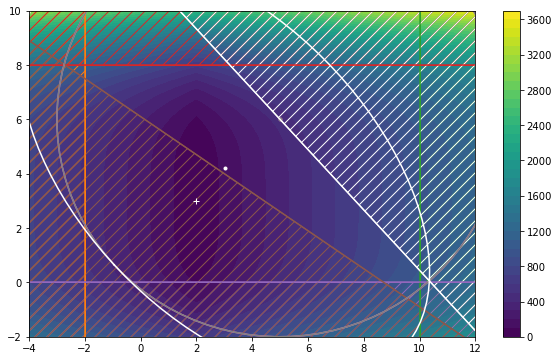

In [5]:
def plot_halfplane_at(vec, pt, ax, *args, **kwargs):  # Plot a halfplane given a normal vector and a point on the plane
    plot_halfplane((vec, ortho_distance(pt, (vec, (0, 0)))), ax, *args, **kwargs)

def show_one_iteration(starting_E, ax):
    w = current_w(starting_E[0])
    plot_ellipse(starting_E, ax, "gray")
    plot_halfplane_at(w, starting_E[0], ax, "w")
    E1 = next_E(starting_E, w)
    plot_ellipse(E1, ax, "w")
    return(E1)

fig, ax = plot_problem()
E1 = show_one_iteration(E0, ax)

Success! The new ellipse is the smallest ellipse that encloses the portion of the initial ellipse not excluded from consideration by the line drawn through the initial point normal to the gradient.

Another iteration?

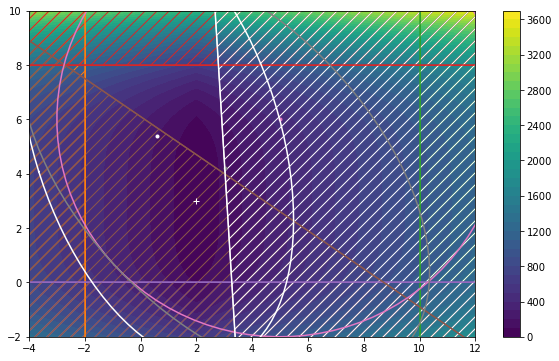

In [6]:
fig, ax = plot_problem()
E2 = show_one_iteration(E1, ax)

Success, but now the candidate point is outside the feasible set. Can we recover?

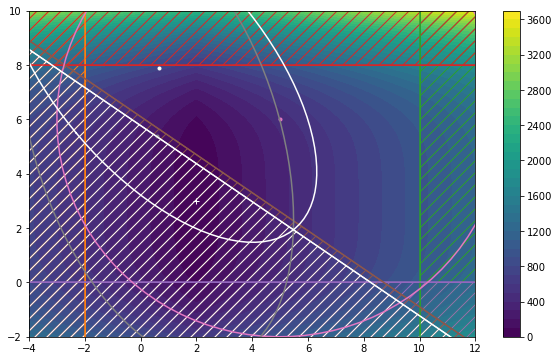

In [7]:
fig, ax = plot_problem()
E3 = show_one_iteration(E2, ax)

Indeed we can. Let's show a bunch of iterations in sequence:

[2.03330848 4.56490249]


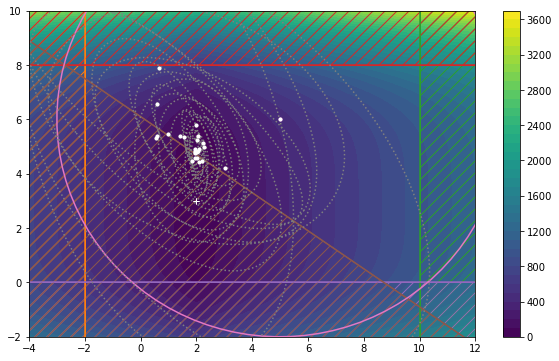

In [8]:
def show_many_iterations(starting_E, n_iters, ax):
    E = starting_E
    Es = []
    Es.append(starting_E)
    for i in range(n_iters):
        w = current_w(E[0])
        # plot_halfplane_at(w, E[0], ax, "gray", ls=":", do_hatch=False)
        E = next_E(E, w)
        # print(E)
        Es.append(E)
        plot_ellipse(E, ax, "gray", ls=":")
    for Em in Es:
        plt.plot(*Em[0], "w.")
    return Es
fig, ax = plot_problem()
Es = show_many_iterations(E0, 25, ax)
# plot_ellipse(Es[-1], ax, "w")
ax.plot(x0, y0, "w+")
plt.plot()
print(final_x([te[0] for te in Es]))

Just to demonstrate that we can accurately converge on the analytical result if there's not a constraint in the way, let's move the active constraint:

Final solution: [2.00002805 3.00229307]


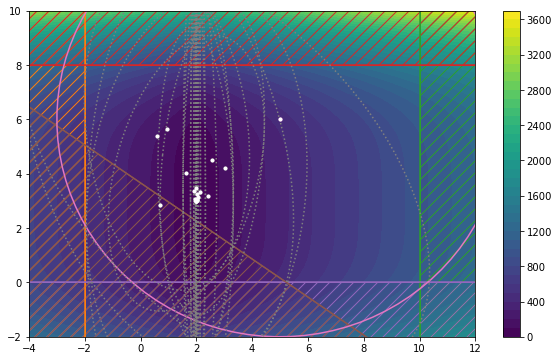

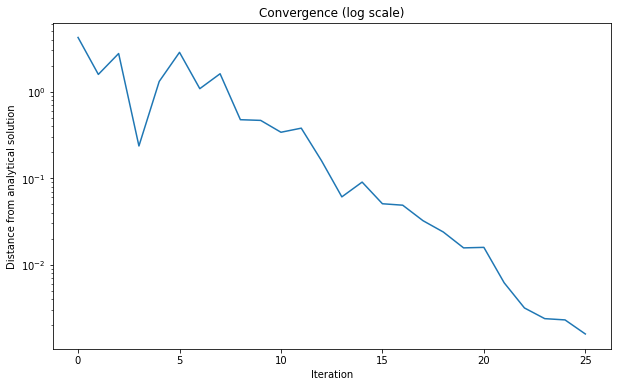

In [9]:
constraints_stack = constraints
constraints = [  # Overwrite constraints to test alternate configuration
    [(-1, 0), 2],
    [(1, 0), 10],
    [(0, 1), 8],
    [(0, -1), 0],
    [(-7, -10), -3]]
for c in constraints: c[0] = normalize(c[0])
plot_problem()
Es = show_many_iterations(E0, 25, ax)
ax.plot(x0, y0, "w+")
fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(list(range(len(Es))), [np.linalg.norm(te[0]-np.array([x0, y0])) for te in Es])
ax2.set_ylabel("Distance from analytical solution")
ax2.set_xlabel("Iteration")
ax2.set_yscale("log")
ax2.set_title("Convergence (log scale)")
plt.plot()
print("Final solution:", final_x([te[0] for te in Es]))
constraints = constraints_stack  # Restore state

Success!